# VIS: Model \#2
## Siamese Fusion Discrimination Network for Video-Audio Matching

In [1]:
COLAB = False

In [2]:
if COLAB:
    from tqdm.notebook import tqdm
    from google.colab import drive

    drive.mount('/content/drive')

    %cd /content/drive/MyDrive/MIT6-8300_Computer_Vision/Visually-Indicated-Sounds/
else:
    from tqdm import tqdm

In [3]:
import os
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import copy as copy

from dataloader import VideoAudioDataset, VATransform, ResamplingSampler

from constants import AUDIO_SAMPLE_RATE

# !! Put data file location in file `data_filepath`
# If file `data_filepath` does not exist, assume data is located in root
filepath = 'vis-data-256/vis-data-256/'

if os.path.isfile('data_filepath'):
    with open('data_filepath', 'r') as f:
        filepath = f.readline() + filepath

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print("Active device: ", device)

Active device:  cuda


## Model structure

In [4]:
class FusionVIS(nn.Module):
    def __init__(self):
        super(FusionVIS, self).__init__()

        # audio preprocessing
        self.audio_preprocess = nn.Sequential(
            MelSpectrogram(sample_rate=AUDIO_SAMPLE_RATE, n_fft=2048, hop_length=512, n_mels=128),
            AmplitudeToDB()
        )

        # resnet backbone
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.backbone.fc = nn.Identity()

        # define convolutional layers
        # self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        # self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # video

        # define fully connected layers
        self.fc1 = nn.Linear(in_features=4096, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=1)

    def forward(self, video, audio):
          batch_size, seq_len, c, h, w = video.size()
          video = video.view(batch_size*seq_len, c, h, w)

          # audio preprocessing
          spectrogram = self.audio_preprocess(audio)
          spec_3 = spectrogram.unsqueeze(1).repeat(1, 3, 1, 1) # Don't forget to unsqueeze(1) to keep batch_size!

          # backbone
          video = self.backbone(video)
          audio_feat = self.backbone(spec_3)
          
          # print("Audio postprocessing: (nothing to do)")
          # print(audio_feat.shape)

          # print("Video postprocessing:")
          # print(video.shape)
          video = video.reshape(batch_size, seq_len, -1) # This is debatable: we are forcing (batch_size ,X) from arbitrary shape - labels are mixed??
          # print(video.shape)
          video_feat = torch.max(video, dim=1)[0]
          # print(video_feat.shape)

          # concatenation
          # print("Final concat:")
          # print(video_feat.shape)
          # print(audio_feat.shape)
          fusion = torch.cat([video_feat, audio_feat], dim=1)

          fusion = self.fc1(fusion)
          fusion = F.relu(fusion)
          fusion = self.fc2(fusion)
          fusion = F.relu(fusion)
          fusion = self.fc3(fusion)
          fusion = F.sigmoid(fusion)

          return fusion.squeeze()

In [5]:
fusion_model = FusionVIS().to(device)

## Training

In [6]:
RANDOM_SEGMENT_SECONDS = 0.5

N_EPOCHS = 10
TRAIN_DATASET_SUBSAMPLE_SIZE = 780
VAL_DATASET_SUBSAMPLE_SIZE = 96
TEST_DATASET_SUBSAMPLE_SIZE = 96
RESAMPLED_BATCH_SIZE = 4
BATCH_SIZE = 4

# Dataset setup

train_filenames = np.load('datasets/train_dataset.npy')
val_filenames = np.load('datasets/val_dataset.npy')
test_filenames = np.load('datasets/test_dataset.npy')

# File '2015-09-12-04-15-35-1_mic.wav' is corrupted
train_filenames = train_filenames[train_filenames[:, 1] != '2015-09-12-04-15-35-1_mic.wav']

train_filenames = train_filenames[:TRAIN_DATASET_SUBSAMPLE_SIZE,]
val_filenames = val_filenames[:VAL_DATASET_SUBSAMPLE_SIZE,]
test_filenames = test_filenames[:TEST_DATASET_SUBSAMPLE_SIZE,]

print("Training set size: ", train_filenames.shape)
print("Validation set size: ", val_filenames.shape)
print("Test set size: ", test_filenames.shape)

transforms = [VATransform.RANDOM_SEGMENT, 
                    VATransform.IMG_DOWNSAMPLE,
                    VATransform.FRAME_DOWNSAMPLE,
                    VATransform.DATA_AUGMENT]

transform_args = {'random_segment_seconds': RANDOM_SEGMENT_SECONDS,
                        'img_downsample_factor': 5,
                        'frame_downsample_factor': 6}

train_dataset = VideoAudioDataset(train_filenames, device, filepath_prefix=filepath, transform=transforms, **transform_args)
val_dataset = VideoAudioDataset(val_filenames, device, filepath_prefix=filepath, transform=transforms, **transform_args)
test_dataset = VideoAudioDataset(test_filenames, device, filepath_prefix=filepath, transform=transforms, **transform_args)

train_sampler = ResamplingSampler(train_dataset, batch_size=RESAMPLED_BATCH_SIZE, no_batches=TRAIN_DATASET_SUBSAMPLE_SIZE//RESAMPLED_BATCH_SIZE, replacement=True)

train_loader = DataLoader(train_dataset, batch_sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Training set size:  (780, 3)
Validation set size:  (96, 3)
Test set size:  (96, 3)


In [7]:
# Starting point
fusion_model.load_state_dict(torch.load('model_weights/fusion50_1_weights.pt'))           

<All keys matched successfully>

In [8]:
dataloaders = {'train':train_loader, 'val':val_loader}

criterion = nn.BCELoss()
optimizer= optim.Adam(fusion_model.parameters(), lr=0.01)

since = time.time()

train_arr_loss = []
train_arr_acc = []
val_arr_loss = []
val_arr_acc = []

best_model_wts = copy.deepcopy(fusion_model.state_dict())
best_acc = 0.0

for epoch in range(N_EPOCHS):

  print('Epoch {}/{}'.format(epoch + 1, N_EPOCHS))
  print('-' * 10)

  for phase in ['train', 'val']:

    if phase == 'train':
      fusion_model.train()
    else:
      fusion_model.eval()

    c_loss = 0.0
    c_total = 0
    c_corrects = 0

    loader = dataloaders[phase]

    for video_feat, audio_feat, label in tqdm(dataloaders[phase]):
      video_feat = video_feat.to(device)
      audio_feat = audio_feat.to(device)
      label = label.to(device)

      optimizer.zero_grad()

      with torch.set_grad_enabled(phase == 'train'):

        output = fusion_model(video_feat, audio_feat)
        loss = criterion(output, label.float())

        pred = torch.round(output)

        if phase == 'train':
          loss.backward()
          optimizer.step()

      c_loss += loss.item()
      c_total += label.size(0)
      c_corrects += (pred == label).sum().item()

      torch.cuda.empty_cache()

    epoch_loss = c_loss / len(dataloaders[phase].dataset)
    epoch_acc = 1.0*c_corrects / len(dataloaders[phase].dataset)

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    if phase == 'val' and epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model_wts = copy.deepcopy(fusion_model.state_dict())
    if phase == 'train':
      train_arr_loss.append(epoch_loss)
      train_arr_acc.append(epoch_acc)
    if phase == 'val':
      val_arr_loss.append(epoch_loss)
      val_arr_acc.append(epoch_acc)

  print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

Epoch 1/10
----------


  0%|          | 0/195 [00:00<?, ?it/s]c:\Users\ysjan\miniconda3\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 195/195 [09:33<00:00,  2.94s/it]


train Loss: 0.0893 Acc: 0.8872


100%|██████████| 24/24 [04:04<00:00, 10.20s/it]


val Loss: 0.2392 Acc: 0.4896

Epoch 2/10
----------


100%|██████████| 195/195 [09:30<00:00,  2.93s/it]


train Loss: 0.0847 Acc: 0.8795


100%|██████████| 24/24 [00:46<00:00,  1.92s/it]


val Loss: 0.4811 Acc: 0.5833

Epoch 3/10
----------


100%|██████████| 195/195 [10:29<00:00,  3.23s/it]


train Loss: 0.0730 Acc: 0.9090


100%|██████████| 24/24 [00:44<00:00,  1.87s/it]


val Loss: 0.2279 Acc: 0.5833

Epoch 4/10
----------


100%|██████████| 195/195 [10:02<00:00,  3.09s/it]


train Loss: 0.0587 Acc: 0.9231


100%|██████████| 24/24 [00:45<00:00,  1.91s/it]


val Loss: 0.1842 Acc: 0.5104

Epoch 5/10
----------


100%|██████████| 195/195 [09:50<00:00,  3.03s/it]


train Loss: 0.0785 Acc: 0.9000


100%|██████████| 24/24 [00:44<00:00,  1.85s/it]


val Loss: 0.2098 Acc: 0.4792

Epoch 6/10
----------


100%|██████████| 195/195 [10:09<00:00,  3.13s/it]


train Loss: 0.0660 Acc: 0.9205


100%|██████████| 24/24 [00:43<00:00,  1.79s/it]


val Loss: 0.4160 Acc: 0.5104

Epoch 7/10
----------


100%|██████████| 195/195 [09:54<00:00,  3.05s/it]


train Loss: 0.1192 Acc: 0.8192


100%|██████████| 24/24 [00:46<00:00,  1.92s/it]


val Loss: 0.1931 Acc: 0.4896

Epoch 8/10
----------


100%|██████████| 195/195 [09:59<00:00,  3.07s/it]


train Loss: 0.1743 Acc: 0.6154


100%|██████████| 24/24 [00:44<00:00,  1.85s/it]


val Loss: 0.7643 Acc: 0.5104

Epoch 9/10
----------


100%|██████████| 195/195 [10:15<00:00,  3.15s/it]


train Loss: 0.0932 Acc: 0.8487


100%|██████████| 24/24 [00:43<00:00,  1.83s/it]


val Loss: 0.6870 Acc: 0.5729

Epoch 10/10
----------


100%|██████████| 195/195 [10:25<00:00,  3.21s/it]


train Loss: 0.0562 Acc: 0.9321


100%|██████████| 24/24 [00:45<00:00,  1.89s/it]

val Loss: 0.7941 Acc: 0.5104

Training complete in 111m 0s
Best val Acc: 0.583333


In [9]:
# RENAME SAVE FILE AFTER SAVE!
torch.save(best_model_wts, 'model_weights/weights_best_val_acc.pt')
np.save('model_logs/loss_acc_logs/train_arr_loss.npy', train_arr_loss)
np.save('model_logs/loss_acc_logs/train_arr_acc.npy', train_arr_acc)
np.save('model_logs/loss_acc_logs/val_arr_loss.npy', val_arr_loss)
np.save('model_logs/loss_acc_logs/val_arr_acc.npy', val_arr_acc)

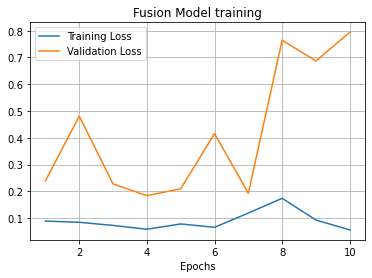

In [10]:
plt.plot(range(1,N_EPOCHS+1),train_arr_loss, label="Training Loss")
plt.plot(range(1,N_EPOCHS+1),val_arr_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.legend()
plt.grid()
plt.title("Fusion Model training")
plt.show()

## Testing

In [11]:
torch.cuda.empty_cache()

In [15]:
# fusion_model.load_state_dict(torch.load('model_weights/fusion_3_weights.pt'))

In [13]:
fusion_model.eval()

preds = []
correct = 0
total = 0

with torch.no_grad():
  for video_feat, audio_feat, label in tqdm(test_loader):
    video_feat = video_feat.to(device)
    audio_feat = audio_feat.to(device)
    label = label.to(device)
    output = fusion_model(video_feat, audio_feat)
    pred = torch.round(output)
    preds.append(pred.unsqueeze(0))
    total += label.size(0)
    correct += (pred == label).sum().item()
    torch.cuda.empty_cache()


100%|██████████| 24/24 [02:21<00:00,  5.91s/it]

Accuracy on 96 test samples: 0.5104166666666666


In [16]:
print(f"Accuracy on {total} test samples: {correct/total}")

Accuracy on 96 test samples: 0.5104166666666666


## Misc.

In [14]:
preds

[tensor([[1., 1., 1., 1.]], device='cuda:0'),
 tensor([[1., 1., 1., 1.]], device='cuda:0'),
 tensor([[1., 1., 1., 1.]], device='cuda:0'),
 tensor([[1., 1., 1., 1.]], device='cuda:0'),
 tensor([[1., 1., 1., 1.]], device='cuda:0'),
 tensor([[1., 1., 1., 1.]], device='cuda:0'),
 tensor([[1., 1., 1., 1.]], device='cuda:0'),
 tensor([[1., 1., 1., 1.]], device='cuda:0'),
 tensor([[1., 1., 1., 1.]], device='cuda:0'),
 tensor([[1., 1., 1., 1.]], device='cuda:0'),
 tensor([[1., 1., 1., 1.]], device='cuda:0'),
 tensor([[1., 1., 1., 1.]], device='cuda:0'),
 tensor([[1., 1., 1., 1.]], device='cuda:0'),
 tensor([[1., 1., 1., 1.]], device='cuda:0'),
 tensor([[1., 1., 1., 1.]], device='cuda:0'),
 tensor([[1., 1., 1., 1.]], device='cuda:0'),
 tensor([[1., 1., 1., 1.]], device='cuda:0'),
 tensor([[1., 1., 1., 1.]], device='cuda:0'),
 tensor([[1., 1., 1., 1.]], device='cuda:0'),
 tensor([[1., 1., 1., 1.]], device='cuda:0'),
 tensor([[1., 1., 1., 1.]], device='cuda:0'),
 tensor([[1., 1., 1., 1.]], device